## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [32]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

cross-entropy

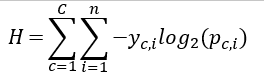

focal loss

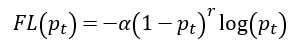

In [33]:
train, test = keras.datasets.cifar10.load_data()

In [34]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [35]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [36]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [37]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [38]:
import tensorflow as tf
import keras.backend as K

def combined_loss(gamma=2., alpha=4., ce_weight=0.7, fl_weight=0.3):
    gamma = float(gamma)
    alpha = float(alpha)

    def loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        
#         print("y_true before convert:",y_true)
#         print("y_pred before convert:",y_pred)
        
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
#         print("y_true after convert:",y_true)
#         print("y_pred after convert:",y_pred)
        
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        cel = keras.losses.categorical_crossentropy(y_true, y_pred)
        return (ce_weight*cel) + (fl_weight * tf.reduce_mean(reduced_fl))
    return loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [39]:
import itertools
results = {}

for i, ce_weight in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_weight))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)

    model.compile(loss=combined_loss(ce_weight=ce_weight,fl_weight=1-ce_weight),
                  metrics=["accuracy"],
                  optimizer=optimizer)    

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_22 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_23 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_24 (Batc (None, 128) 

50000/50000 [==============================] - 4s 88us/step - loss: 0.0991 - acc: 0.9908 - val_loss: 6.4702 - val_acc: 0.4774
Epoch 50/50
50000/50000 [==============================] - 4s 88us/step - loss: 0.0932 - acc: 0.9911 - val_loss: 6.5387 - val_acc: 0.4725
Numbers of exp: 1, ce_weight: 0.30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256) 

Epoch 48/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.1831 - acc: 0.9785 - val_loss: 5.0144 - val_acc: 0.4786
Epoch 49/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.1692 - acc: 0.9818 - val_loss: 5.0874 - val_acc: 0.4761
Epoch 50/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.1574 - acc: 0.9842 - val_loss: 5.2441 - val_acc: 0.4740
Numbers of exp: 2, ce_weight: 0.50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)  

50000/50000 [==============================] - 4s 84us/step - loss: 0.2664 - acc: 0.9628 - val_loss: 3.9332 - val_acc: 0.4774
Epoch 47/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.2498 - acc: 0.9669 - val_loss: 3.9691 - val_acc: 0.4787
Epoch 48/50
50000/50000 [==============================] - 4s 86us/step - loss: 0.2320 - acc: 0.9714 - val_loss: 4.0781 - val_acc: 0.4818
Epoch 49/50
50000/50000 [==============================] - 4s 86us/step - loss: 0.2161 - acc: 0.9737 - val_loss: 4.0867 - val_acc: 0.4815
Epoch 50/50
50000/50000 [==============================] - 4s 86us/step - loss: 0.2044 - acc: 0.9764 - val_loss: 4.1381 - val_acc: 0.4766
Numbers of exp: 3, ce_weight: 0.70
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)  

Epoch 45/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.3795 - acc: 0.9331 - val_loss: 2.9702 - val_acc: 0.4820
Epoch 46/50
50000/50000 [==============================] - 4s 90us/step - loss: 0.3582 - acc: 0.9367 - val_loss: 3.0665 - val_acc: 0.4796
Epoch 47/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.3382 - acc: 0.9431 - val_loss: 3.1506 - val_acc: 0.4814
Epoch 48/50
50000/50000 [==============================] - 4s 88us/step - loss: 0.3208 - acc: 0.9464 - val_loss: 3.0738 - val_acc: 0.4783
Epoch 49/50
50000/50000 [==============================] - 4s 88us/step - loss: 0.3016 - acc: 0.9521 - val_loss: 3.1747 - val_acc: 0.4748
Epoch 50/50
50000/50000 [==============================] - 4s 90us/step - loss: 0.2865 - acc: 0.9568 - val_loss: 3.1807 - val_acc: 0.4783
Numbers of exp: 4, ce_weight: 1.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input

50000/50000 [==============================] - 4s 89us/step - loss: 0.6169 - acc: 0.8117 - val_loss: 1.6054 - val_acc: 0.4908
Epoch 44/50
50000/50000 [==============================] - 5s 90us/step - loss: 0.6000 - acc: 0.8199 - val_loss: 1.6067 - val_acc: 0.4842
Epoch 45/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.5803 - acc: 0.8286 - val_loss: 1.6418 - val_acc: 0.4874
Epoch 46/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.5647 - acc: 0.8325 - val_loss: 1.6254 - val_acc: 0.4891
Epoch 47/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.5490 - acc: 0.8384 - val_loss: 1.6351 - val_acc: 0.4870
Epoch 48/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.5300 - acc: 0.8469 - val_loss: 1.6517 - val_acc: 0.4864
Epoch 49/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.5133 - acc: 0.8542 - val_loss: 1.6710 - val_acc: 0.4873
Epoch 50/50
50000/50000 [=====================

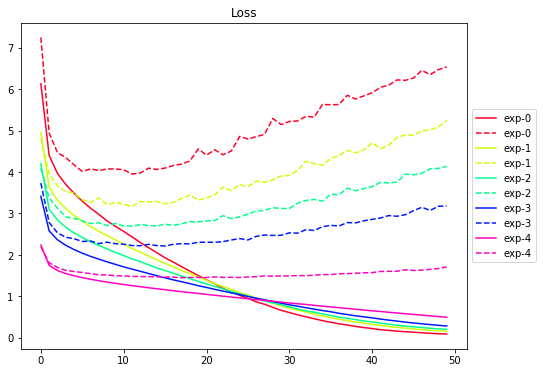

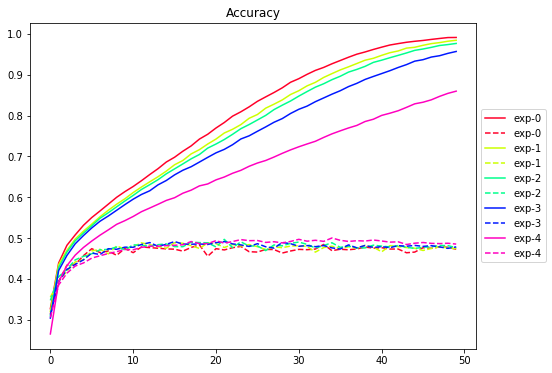

In [40]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()